# Stochastic Variational Deep Kernel Learning (SVDKL) Tutorial

This notebook tutorial on SVDKL related to computer vision tasks is made possible by [GPyTorch](https://docs.gpytorch.ai/en/v1.6.0/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html). Please refer to the embedded link for more details and the original github page tutorial.

My version of the tutorial...

# Part 1: Libraries + Data Processing

In [1]:
# Run this line if not already installed
!pip install gpytorch

In [2]:
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from torch import nn
import torch
import os
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision
import gpytorch
import math
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
%matplotlib inline

With our packages installed, let's begin loading in our data. We will use CIFAR-10 with data augmentations.

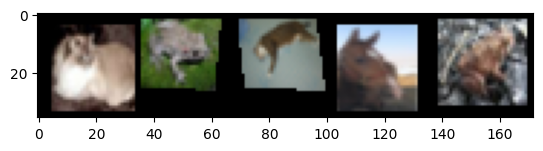

In [3]:
# Define data augmentations for more diverse data
train_transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load in the data
train_set = dset.CIFAR10('data', train=True, transform=train_transform, download=True)
test_set = dset.CIFAR10('data', train=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)
num_classes = 10

# Visualize some training images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Visualize 5 images
imshow(torchvision.utils.make_grid(images[:5]))

# Part 2: Feature Extractor

With our data out of the way, let's define our neural network feature extractor. The output of the feature extractor is a latent embedding space. This latent space will then be processed by the GP layer. For simplicity, we will use DenseNet to get started quickly.

In [4]:
class DenseNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load base DenseNet model
        base_model = torchvision.models.densenet121()

        # Save only the feature extractor part (everything except the classifier)
        self.features = base_model.features
        self.avgpool_size = 7

        # Store the classifier in_features so we know the feature dimension
        self.num_features = base_model.classifier.in_features

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        return out

# Example: instantiate feature extractor
feature_extractor = DenseNetFeatureExtractor()
num_features = feature_extractor.num_features
print("Output feature dimension:", num_features)

Output feature dimension: 1024


# Part 3: GP Layer

Now we'll implement the GP output layer. This layer will use the outputs from the feature extractor and assign one GP per feature. [Per the paper](https://arxiv.org/pdf/1611.00336):

"Model Training For our deep kernel learning model, we used deep neural networks which produce $C$-dimensional top-level features. Here $C$ is the number of classes. We place a Gaussian process on each dimension of these features. We used RBF base kernels. The additive GP layer is then followed by a linear mixing layer $A \in \mathbb{R}^{C × C}$. We initialized $A$ to be an identity matrix, and optimized in the joint learning procedure to recover cross-dimension correlations from data."

In other words, if we naïvely put one independent GP per class, we don't get any sharing between classes, and there's a good chance they'll overfit.

The solution is to put a latent GP on each dimension (in this case 1024 latent GPs) and combine these independent GPs together into mixing matrix $A$ so that they can share information.

In [5]:
class GaussianProcessLayer(gpytorch.models.ApproximateGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
        )

        # Our base variational strategy is a GridInterpolationVariationalStrategy,
        # which places variational inducing points on a Grid
        # We wrap it with a IndependentMultitaskVariationalStrategy so that our output is a vector-valued GP
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.GridInterpolationVariationalStrategy(
                self, grid_size=grid_size, grid_bounds=[grid_bounds],
                variational_distribution=variational_distribution,
            ), num_tasks=num_dim,
        )
        super().__init__(variational_strategy)

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# Part 4: SVDKL Composition

With both a feature extractor and GP definition set up, let's now define our SVDKL model composition. The goal is to:
1. Output a latent embedding space from the feature extractor;
2. Pass latent information into the GP layer so that each latent GP can model a latent feature dimension;
3. Evaluate all GPs to get a vector of latent GP outputs
4. Utilize the mixing layer to produce class logits as a weighted sum of all 1024 GP outputs
5. Compute softmax from logits and output classification

In [6]:
class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim

        # This module will scale the NN features so that they're nice values
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(self.grid_bounds[0], self.grid_bounds[1])

    def forward(self, x):
        features = self.feature_extractor(x)
        features = self.scale_to_bounds(features)
        # This next line makes it so that we learn a GP for each feature
        features = features.transpose(-1, -2).unsqueeze(-1)
        res = self.gp_layer(features)
        return res

model = DKLModel(feature_extractor, num_dim=num_features)
likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=model.num_dim, num_classes=num_classes)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Part 5: Training

In [ ]:
# Training Params
n_epochs = 100
lr = 0.05
optimizer = SGD([
    {'params': model.feature_extractor.parameters(), 'weight_decay': 1e-4},
    {'params': model.gp_layer.hyperparameters(), 'lr': lr * 0.01},
    {'params': model.gp_layer.variational_parameters()},
    {'params': likelihood.parameters()},
], lr=lr, momentum=0.9, nesterov=True, weight_decay=0)
scheduler = MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)
mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader.dataset))

# Metrics
train_losses = []
test_accuracies = []
best_accuracy = -1
best_epoch = 0

def train(epoch):
    model.train()
    likelihood.train()
    epoch_train_loss = 0

    minibatch_iter = tqdm.tqdm(train_loader, desc=f"(Epoch {epoch}) Minibatch")
    with gpytorch.settings.num_likelihood_samples(8):
        for data, target in minibatch_iter:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = -mll(output, target)
            epoch_train_loss += loss

            loss.backward()
            optimizer.step()
            minibatch_iter.set_postfix(loss=loss.item())

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    print('Train set: Average loss: {:.4f}'.format(epoch_train_loss))

def test():
    model.eval()
    likelihood.eval()

    correct = 0
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = likelihood(model(data))  # This gives us 16 samples from the predictive distribution
            pred = output.probs.mean(0).argmax(-1)  # Taking the mean over all of the sample we've drawn
            correct += pred.eq(target.view_as(pred)).cpu().sum()

    test_accuracy = 100. * correct / float(len(test_loader.dataset))
    test_accuracies.append(test_accuracy)
    print('Test set: Accuracy: {}/{} ({}%)'.format(
        correct, len(test_loader.dataset), test_accuracy
    ))

# Commence Training Routine
for epoch in range(1, n_epochs + 1):
    with gpytorch.settings.use_toeplitz(False):
        train(epoch)
        test()
    scheduler.step()

    # Model checkpointing
    if test_accuracies[-1] > best_accuracy:
        best_accuracy = test_accuracies[-1]
        best_epoch = epoch

        # Save model state
        state_dict = model.state_dict()
        likelihood_state_dict = likelihood.state_dict()
        torch.save({'model': state_dict, 'likelihood': likelihood_state_dict}, 'dkl_cifar_chkpt.pt')
        print("New best model found --> model saved!")

# Print final logging statement
print("Training Complete!")
print(f"Best model found at epoch {best_epoch} with testing accuracy {best_accuracy}")

(Epoch 1) Minibatch: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s, loss=1.99]


Test set: Accuracy: 1989/10000 (19.889999389648438%)
New best model found --> model saved!


(Epoch 2) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.42it/s, loss=1.72]


Test set: Accuracy: 1704/10000 (17.040000915527344%)


(Epoch 3) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.42it/s, loss=1.87]


Test set: Accuracy: 3351/10000 (33.5099983215332%)
New best model found --> model saved!


(Epoch 4) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.42it/s, loss=1.9]


Test set: Accuracy: 1584/10000 (15.84000015258789%)


(Epoch 5) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, loss=1.46]


Test set: Accuracy: 4330/10000 (43.29999923706055%)
New best model found --> model saved!


(Epoch 6) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, loss=1.23]


Test set: Accuracy: 5539/10000 (55.38999938964844%)
New best model found --> model saved!


(Epoch 7) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, loss=1.17]


Test set: Accuracy: 5655/10000 (56.54999923706055%)
New best model found --> model saved!


(Epoch 8) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s, loss=0.876]


Test set: Accuracy: 5393/10000 (53.93000030517578%)


(Epoch 9) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s, loss=1.13]


Test set: Accuracy: 4363/10000 (43.630001068115234%)


(Epoch 10) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.971]


Test set: Accuracy: 6399/10000 (63.9900016784668%)
New best model found --> model saved!


(Epoch 11) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.794]


Test set: Accuracy: 4234/10000 (42.34000015258789%)


(Epoch 12) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.88]


Test set: Accuracy: 6739/10000 (67.38999938964844%)
New best model found --> model saved!


(Epoch 13) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.676]


Test set: Accuracy: 7217/10000 (72.16999816894531%)
New best model found --> model saved!


(Epoch 14) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.982]


Test set: Accuracy: 1780/10000 (17.799999237060547%)


(Epoch 15) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.91]


Test set: Accuracy: 7022/10000 (70.22000122070312%)


(Epoch 16) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.45it/s, loss=1.08]


Test set: Accuracy: 6371/10000 (63.709999084472656%)


(Epoch 17) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=1.13]


Test set: Accuracy: 6913/10000 (69.12999725341797%)


(Epoch 18) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.542]


Test set: Accuracy: 7119/10000 (71.19000244140625%)


(Epoch 19) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.45it/s, loss=0.714]


Test set: Accuracy: 7097/10000 (70.97000122070312%)


(Epoch 20) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.525]


Test set: Accuracy: 7450/10000 (74.5%)
New best model found --> model saved!


(Epoch 21) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.634]


Test set: Accuracy: 6218/10000 (62.18000030517578%)


(Epoch 22) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.817]


Test set: Accuracy: 3725/10000 (37.25%)


(Epoch 23) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.52]


Test set: Accuracy: 7668/10000 (76.68000030517578%)
New best model found --> model saved!


(Epoch 24) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s, loss=0.705]


Test set: Accuracy: 7647/10000 (76.47000122070312%)


(Epoch 25) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.593]


Test set: Accuracy: 7391/10000 (73.91000366210938%)


(Epoch 26) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.665]


Test set: Accuracy: 7741/10000 (77.41000366210938%)
New best model found --> model saved!


(Epoch 27) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.566]


Test set: Accuracy: 7662/10000 (76.62000274658203%)


(Epoch 28) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.653]


Test set: Accuracy: 7753/10000 (77.52999877929688%)
New best model found --> model saved!


(Epoch 29) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.516]


Test set: Accuracy: 7671/10000 (76.70999908447266%)


(Epoch 30) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.455]


Test set: Accuracy: 7740/10000 (77.4000015258789%)


(Epoch 31) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.695]


Test set: Accuracy: 6590/10000 (65.9000015258789%)


(Epoch 32) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.45it/s, loss=0.283]


Test set: Accuracy: 7899/10000 (78.98999786376953%)
New best model found --> model saved!


(Epoch 33) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.568]


Test set: Accuracy: 7635/10000 (76.3499984741211%)


(Epoch 34) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.405]


Test set: Accuracy: 7656/10000 (76.55999755859375%)


(Epoch 35) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s, loss=0.362]


Test set: Accuracy: 7711/10000 (77.11000061035156%)


(Epoch 36) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.411]


Test set: Accuracy: 6942/10000 (69.41999816894531%)


(Epoch 37) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.407]


Test set: Accuracy: 7923/10000 (79.2300033569336%)
New best model found --> model saved!


(Epoch 38) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.407]


Test set: Accuracy: 7796/10000 (77.95999908447266%)


(Epoch 39) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.722]


Test set: Accuracy: 7570/10000 (75.69999694824219%)


(Epoch 40) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.304]


Test set: Accuracy: 8157/10000 (81.56999969482422%)
New best model found --> model saved!


(Epoch 41) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.357]


Test set: Accuracy: 7572/10000 (75.72000122070312%)


(Epoch 42) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.282]


Test set: Accuracy: 8019/10000 (80.19000244140625%)


(Epoch 43) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.356]


Test set: Accuracy: 7774/10000 (77.73999786376953%)


(Epoch 44) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.292]


Test set: Accuracy: 8096/10000 (80.95999908447266%)


(Epoch 45) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.478]


Test set: Accuracy: 7701/10000 (77.01000213623047%)


(Epoch 46) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.338]


Test set: Accuracy: 7780/10000 (77.80000305175781%)


(Epoch 47) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.43]


Test set: Accuracy: 8101/10000 (81.01000213623047%)


(Epoch 48) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.301]


Test set: Accuracy: 8052/10000 (80.5199966430664%)


(Epoch 49) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.384]


Test set: Accuracy: 7889/10000 (78.88999938964844%)


(Epoch 50) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.404]


Test set: Accuracy: 8170/10000 (81.69999694824219%)
New best model found --> model saved!


(Epoch 51) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.392]


Test set: Accuracy: 8552/10000 (85.5199966430664%)
New best model found --> model saved!


(Epoch 52) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.255]


Test set: Accuracy: 8618/10000 (86.18000030517578%)
New best model found --> model saved!


(Epoch 53) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s, loss=0.12]


Test set: Accuracy: 8575/10000 (85.75%)


(Epoch 54) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.114]


Test set: Accuracy: 8567/10000 (85.66999816894531%)


(Epoch 55) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.19]


Test set: Accuracy: 8587/10000 (85.87000274658203%)


(Epoch 56) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.131]


Test set: Accuracy: 8584/10000 (85.83999633789062%)


(Epoch 57) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.315]


Test set: Accuracy: 8616/10000 (86.16000366210938%)


(Epoch 58) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.0781]


Test set: Accuracy: 8633/10000 (86.33000183105469%)
New best model found --> model saved!


(Epoch 59) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.254]


Test set: Accuracy: 8583/10000 (85.83000183105469%)


(Epoch 60) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.194]


Test set: Accuracy: 8576/10000 (85.76000213623047%)


(Epoch 61) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.191]


Test set: Accuracy: 8603/10000 (86.02999877929688%)


(Epoch 62) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.0981]


Test set: Accuracy: 8641/10000 (86.41000366210938%)
New best model found --> model saved!


(Epoch 63) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.101]


Test set: Accuracy: 8523/10000 (85.2300033569336%)


(Epoch 64) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.0718]


Test set: Accuracy: 8586/10000 (85.86000061035156%)


(Epoch 65) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.241]


Test set: Accuracy: 8597/10000 (85.97000122070312%)


(Epoch 66) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.19]


Test set: Accuracy: 8600/10000 (86.0%)


(Epoch 67) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.218]


Test set: Accuracy: 8574/10000 (85.73999786376953%)


(Epoch 68) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.0639]


Test set: Accuracy: 8599/10000 (85.98999786376953%)


(Epoch 69) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.247]


Test set: Accuracy: 8582/10000 (85.81999969482422%)


(Epoch 70) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.42it/s, loss=0.145]


Test set: Accuracy: 8566/10000 (85.66000366210938%)


(Epoch 71) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.44it/s, loss=0.0847]


Test set: Accuracy: 8561/10000 (85.61000061035156%)


(Epoch 72) Minibatch: 100%|██████████| 196/196 [01:20<00:00,  2.43it/s, loss=0.0768]


Test set: Accuracy: 8556/10000 (85.55999755859375%)


(Epoch 73) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.41it/s, loss=0.083]


Test set: Accuracy: 8560/10000 (85.5999984741211%)


(Epoch 74) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s, loss=0.156]


Test set: Accuracy: 8557/10000 (85.56999969482422%)


(Epoch 75) Minibatch: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s, loss=0.158]


Test set: Accuracy: 8544/10000 (85.44000244140625%)


(Epoch 76) Minibatch:  36%|███▌      | 70/196 [00:29<00:52,  2.38it/s, loss=0.0877]


KeyboardInterrupt: 

# Part 5.5: Loading Model Checkpoint

With training completed to a specified degree, let's now load our best performing model checkpoint.

In [7]:
# Load best model checkpoint
checkpoint = torch.load('dkl_cifar_chkpt.pt')
model.load_state_dict(checkpoint['model'])
likelihood.load_state_dict(checkpoint['likelihood'])

# Ensure model and likelihood are on the correct device
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

print("Best model checkpoint loaded successfully!")

Best model checkpoint loaded successfully!


# Part 6: Visualizing Results

Before we go any further, let's remind ourselves of why we should even consider using DKL. Although it is generally true, that we can achieve greater classification accuracy by tacking on a GP layer at the end of an NN in this fashion, studies show that this improvement is only by a few percent. The real power, in my opinion, is the ability to quantify uncertainty!

Now, I bet some of you might be wondering: "why can't we just output softmaxed logits? Doesn't that indicate probability and we can infer uncertainty from there?" The answer is $\textbf{no}$. Softmax is a normalized predicitive probability that indicates $\textbf{confidence}$, not certainty. For example, a softmax can be very confident yet completely wrong, especially when labels have intrinsic noise or the model sees out-of-distribution inputs (more on this later).

On the other hand, there exists this notion that GPs have some ability to quantify $\textbf{epistemic uncertainty}$ through mutual information (MI) as it is a form of Bayesian ML. The advantage is that GPs tend to be less overconfident, and allows the user to see how much the model attributes error to model uncertainty vs data noise. As such, we are hoping that GPs attatched to the end of a neural network can, to an extent, evaluate the uncertainty due to lack of data/knowledge!

## Evaluation Helper Function

As such, let's define a helper function to randomly sample from a testing dataset and visualize some results.

TODO: EXPLAIN THE MATH BETTER!!!

In [76]:
def evaluate_epistemic_uncertainty(model, likelihood, test_set,
                                   num_samples=500, display_fraction=0.1,
                                   num_lik_samples=256, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    likelihood.eval()

    # Randomly sample indices from test set
    indices = np.random.choice(len(test_set), size=num_samples, replace=False)
    images = torch.stack([test_set[i][0] for i in indices])
    true_labels = [test_set[i][1] for i in indices] # Keep true labels from the test set (e.g., CIFAR-100)

    images = images.to(device)
    B = images.shape[0]
    eps = 1e-12

    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(num_lik_samples):
        feats = model.feature_extractor(images)
        feats = model.scale_to_bounds(feats)
        feats_in = feats.transpose(-1, -2).unsqueeze(-1)
        posterior = model.gp_layer(feats_in)
        pred_dist = likelihood(posterior)
        probs_samples = pred_dist.probs.detach().cpu().numpy()  # [S, B, C]
        S, _, C_model = probs_samples.shape # Use C_model for the number of classes the model outputs (10)

    # Compute statistics
    mean_probs = probs_samples.mean(axis=0)
    std_probs  = probs_samples.std(axis=0)
    lower95 = np.percentile(probs_samples, 2.5, axis=0)
    upper95 = np.percentile(probs_samples, 97.5, axis=0)

    pred_entropy = -np.sum(mean_probs * np.log(mean_probs + eps), axis=-1)
    entropy_per_sample = -np.sum(probs_samples * np.log(probs_samples + eps), axis=-1)
    expected_entropy = entropy_per_sample.mean(axis=0)
    mutual_info = pred_entropy - expected_entropy

    pred_classes = mean_probs.argmax(axis=-1)

    # Use CIFAR-10 class names for predictions as the model was trained on CIFAR-10
    cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    pred_names = [cifar10_class_names[int(p)] for p in pred_classes]

    # Use the actual class names from the test set for the true labels
    test_set_class_names = list(test_set.classes)
    true_names = [test_set_class_names[int(t)] for t in true_labels]


    # Visualize a fraction of images
    num_display = max(1, int(B * display_fraction))
    display_indices = np.linspace(0, B-1, num_display, dtype=int)

    fig, axs = plt.subplots(num_display, 2, figsize=(12, 3*num_display))
    axs = axs.reshape(-1, 2)

    for display_idx, i in enumerate(display_indices):
        # Show image
        img = images[i].cpu().permute(1,2,0).numpy()
        axs[display_idx,0].imshow(np.clip(img,0,1))
        axs[display_idx,0].axis('off')
        axs[display_idx,0].set_title(f"True: {true_names[i]} | Pred: {pred_names[i]}")

        # Bar chart with uncertainty
        x = np.arange(C_model) # Use C_model (10) for x-axis
        heights = mean_probs[i]
        yerr = std_probs[i]
        axs[display_idx,1].bar(x, heights, yerr=yerr, capsize=3)
        axs[display_idx,1].set_xticks(x)
        axs[display_idx,1].set_xticklabels(cifar10_class_names, rotation=45, ha='right', fontsize=8) # Use CIFAR-10 class names
        axs[display_idx,1].set_xlabel("Class")
        axs[display_idx,1].set_ylabel("Pred Prob")
        axs[display_idx,1].set_title(f"Predictive entropy={pred_entropy[i]:.3f}, MI={mutual_info[i]:.3f}")

        for cind in range(C_model): # Iterate up to C_model (10)
            axs[display_idx,1].plot([cind, cind], [lower95[i,cind], upper95[i,cind]], color='k', linewidth=1)

    plt.tight_layout()
    plt.show()

    # Print summary if needed (uncomment below)
    # for i in range(B):
    #     top_conf = mean_probs[i, pred_classes[i]]
    #     print(f"Image {indices[i]}: true={true_names[i]}, pred={pred_names[i]}, "
    #           f"entropy={pred_entropy[i]:.4f}, MI={mutual_info[i]:.4f}, top_conf={top_conf:.3f}")

    return {
        "mean_probs": mean_probs,
        "std_probs": std_probs,
        "pred_entropy": pred_entropy,
        "mutual_info": mutual_info,
        "pred_classes": pred_classes,
        "pred_names": pred_names,
        "true_names": true_names,
        "indices": indices
    }

## CIFAR 10 Test

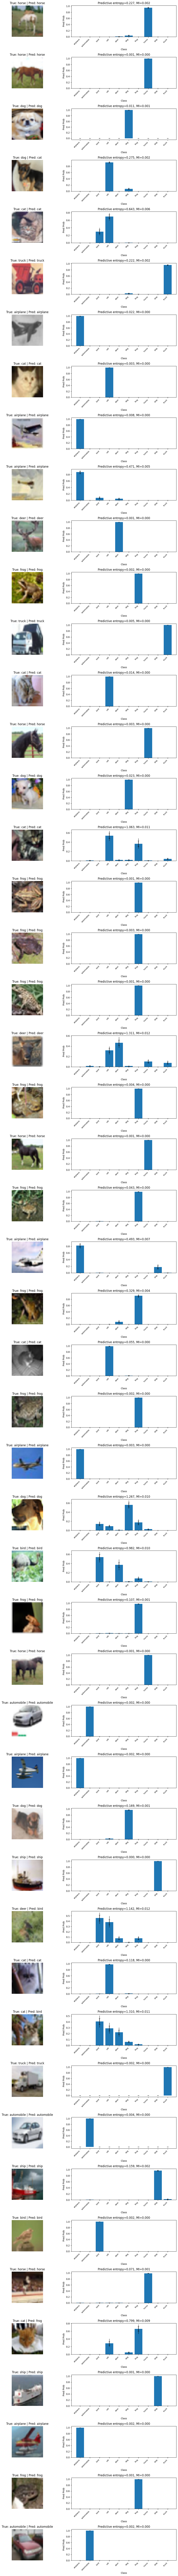

In [77]:
cifar_10_results = evaluate_epistemic_uncertainty(model, likelihood, test_set)

Awesome! So far so good! We can see that in general, the epistemic uncertainty is pretty low. Some things to note:

- Predictive Entropy = Epistemic Uncertainty $+$ Aleatoric Uncertainty
  - This means that higher entropy with lower epistemic uncertainty implies the existence of non-negligible aleatoric uncertainty (image noise).

## CIFAR 100 Test (OOD)

For this final analysis, let's see if the model can detect an image that is not supposed to be in this data set!

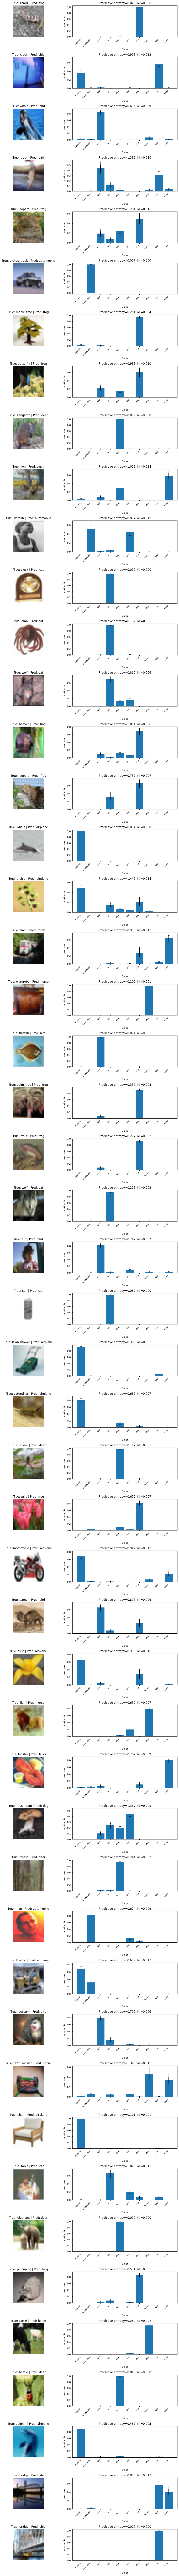

In [78]:
cifar_100_test_set = dset.CIFAR100('data', train=False, transform=test_transform, download=True)
cifar_100_test_loader = torch.utils.data.DataLoader(cifar_100_test_set, batch_size=256, shuffle=False)
num_classes = 100

# Visualize some cifar testing images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

cifar_100_results = evaluate_epistemic_uncertainty(model, likelihood, cifar_100_test_set)

## Analysis of Mutual Information

We can now form histograms to compare the MI distribution between CIFAR 10 images and CIFAR 100 images to determine if SVDKL is a model capable of recognizing epistemic uncertainty.

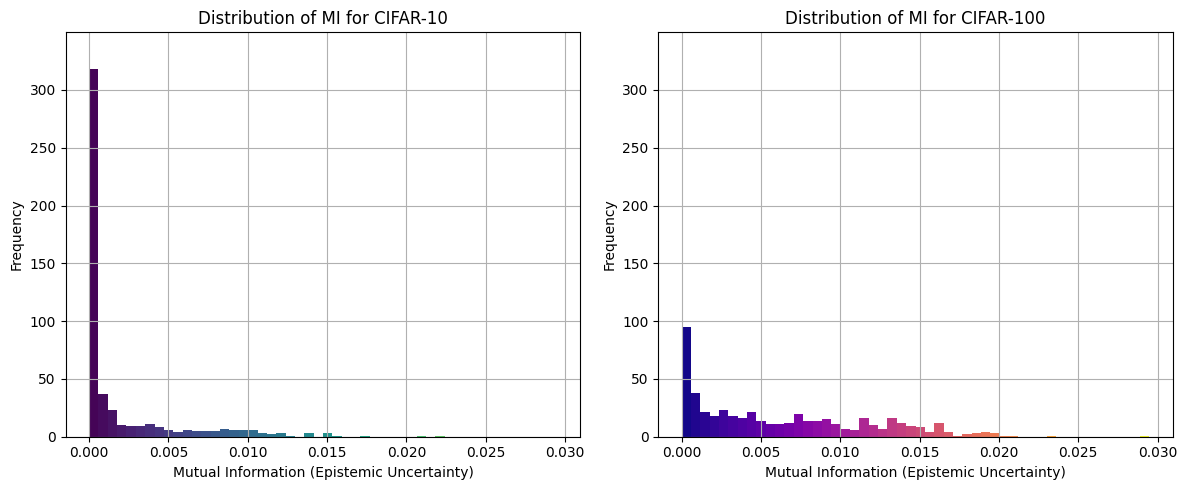

In [79]:
# Plot histograms of mutual information for CIFAR-10 and CIFAR-100 side-by-side
plt.figure(figsize=(12, 5))

# Determine the common range for the x-axis (mutual information)
all_mutual_info = np.concatenate((cifar_10_results['mutual_info'], cifar_100_results['mutual_info']))
min_mi = np.min(all_mutual_info)
max_mi = np.max(all_mutual_info)

# Use a consistent number of bins across the common range
num_bins = 50 # You can adjust this number as needed

# Histogram for CIFAR-10 mutual information
plt.subplot(1, 2, 1)
n_cifar10, bins_cifar10, patches_cifar10 = plt.hist(cifar_10_results['mutual_info'], bins=num_bins, range=(min_mi, max_mi))
plt.xlabel("Mutual Information (Epistemic Uncertainty)")
plt.ylabel("Frequency")
plt.title("Distribution of MI for CIFAR-10")
plt.grid(True)

# Apply color gradient to CIFAR-10 histogram bars
cm_cifar10 = plt.cm.viridis
bin_centers_cifar10 = 0.5 * (bins_cifar10[:-1] + bins_cifar10[1:])
# Normalize color based on the full range of MI
col_cifar10 = (bin_centers_cifar10 - min_mi) / (max_mi - min_mi)
for patch, color in zip(patches_cifar10, cm_cifar10(col_cifar10)):
    patch.set_facecolor(color)

# Histogram for CIFAR-100 mutual information
plt.subplot(1, 2, 2)
n_cifar100, bins_cifar100, patches_cifar100 = plt.hist(cifar_100_results['mutual_info'], bins=num_bins, range=(min_mi, max_mi), color='orange')
plt.xlabel("Mutual Information (Epistemic Uncertainty)")
plt.ylabel("Frequency")
plt.title("Distribution of MI for CIFAR-100")
plt.grid(True)

# Apply color gradient to CIFAR-100 histogram bars
cm_cifar100 = plt.cm.plasma # Using a different colormap for distinction
bin_centers_cifar100 = 0.5 * (bins_cifar100[:-1] + bins_cifar100[1:])
# Normalize color based on the full range of MI
col_cifar100 = (bin_centers_cifar100 - min_mi) / (max_mi - min_mi)
for patch, color in zip(patches_cifar100, cm_cifar100(col_cifar100)):
    patch.set_facecolor(color)

# Set the same y-axis limits for both subplots
max_freq = max(n_cifar10.max(), n_cifar100.max())
plt.subplot(1, 2, 1).set_ylim([0, max_freq * 1.1])
plt.subplot(1, 2, 2).set_ylim([0, max_freq * 1.1])

plt.tight_layout()
plt.show()

# Part 7: Conclusions and Discussion

Based on the above plots, it is plausible to say that SVDKL is a promising model composition for detecting epistemic uncertainty in a given testing data set. We can see that the MI is, on average, higher in CIFAR 100 compared to CIFAR 10, indicating that there is some level of epistemic uncertainty recognized in OOD data. This is a super exciting result, and could have future impliations on trustworthy ML!

Before we get carried away in the excitement, let's remeber a few things:
1. In our example, there is still a decent portion of data that overlaps in MI despite the CIFAR 100 images being OOD to CIFAR 10.
    - Finding a way to more clearly emphasize the OOD-ness of CIFAR 100 would be greatly beneficial.
    - On the other hand, it could also be that those specific CIFAR 100 images were very close to what the model had seen in CIFAR 10, and were plausibly similar in many cases. More analysis would need to be done on this before we can say anything further, though.

2. A potentially limiting factor in using an NN feature extractor is ensuring that the latent output space that the GP layer reads from is appropriately handled. In other words:
    - It is possible that the NN could collapse different inputs together, resulting int the GP kernels losing expressivity over the data.
    - It is also possible that the NN could excessively stretch the latent space, resulting in the kernels overfitting on low-density areas.
    - As a result, it would be a good idea to try and regularize the feature extractor by ensuring it is Lipschitz (better yet, bi-Lipschitz!). This can be done by taking the spectral norm of the weight matrices' leading eigenvalues to provide upper bound, and taking Jacobian norm to lower bound. It suffices to say that this a very difficult task to do efficiently for large NN.
    - The result would theoretically be that we could guarantee the geometry of the input space is not destroyed by NN before GP can see it!